In [1]:
import os
import json

root_json = '/workspaces/solidity/json'
for json_file in os.listdir(root_json):
    with open(os.path.join(root_json, json_file), 'r') as f:
        items = json.load(f)
    print(json_file, len(items))

smartbugs.json 143
error.json 388
clean.json 2354
solidifi.json 350


In [21]:
import os 

dir = '/workspaces/solidity/integrate_dataset'
for vuln in os.listdir(dir):
    if vuln == 'clean':
        continue
    path = os.path.join(dir, vuln, 'integrate', 'vulnerabilities.json')
    new_path = os.path.join(dir, vuln, 'integrate', 'vuln_vulnerabilities.json')
    os.rename(path, new_path)

In [2]:
import json

path_error = '/workspaces/solidity/error.json'
path_clean = '/workspaces/solidity/integrate_dataset/clean/clean_vulnerabilities.json'

with open(path_error, 'r') as f:
    item_error = json.load(f)

with open(path_clean, 'r') as f:
    item_clean = json.load(f)

for error in item_error:
    for clean in item_clean:
        if error['name'] == clean['name']:
            clean['version'] = '0.5.0'

with open(path_clean, 'w') as f:
     json.dump(item_clean, f)


In [30]:
import os
import networkx as nx

cfg_path = '/workspaces/solidity/integrate_dataset/other/integrate/cfg.gpickle'
cfg = nx.read_gpickle(cfg_path)

all_function = {}
for node, node_data in cfg.nodes(data=True):
    if node_data['source_file'] not in all_function.keys():
        all_function[node_data['source_file']] = []
    if node_data['node_type'] == 'FUNCTION':
        all_function[node_data['source_file']].append(node_data['node_token'])

In [31]:
import os
import networkx as nx

cg_path = '/workspaces/solidity/integrate_dataset/other/integrate/cg.gpickle'
cg = nx.read_gpickle(cg_path)

all_function_cg = {}
for node, node_data in cg.nodes(data=True):
    # print(node_data['source_file'])
    if node_data['source_file'] not in all_function_cg.keys():
        all_function_cg[node_data['source_file']] = []
    if node_data['node_type'].split('_')[-1] == 'function':
        all_function_cg[node_data['source_file']].append(node_data['node_token'])

In [32]:
for file in all_function:
    print(len(all_function[file]))

6
2
8
38
65
22


In [33]:
for file in all_function_cg:
    print(len(all_function_cg[file]))

5
1
7
21
42
20


In [173]:

import os
import json
import subprocess
import networkx as nx
from slither.slither import Slither

def get_path_and_version(error_dir):
    path_version_dir = []
    dataset_dir = '/workspaces/solidity/integrate_dataset'

    for error_ in os.listdir(error_dir):
        error_name = error_.split('_error.json')[0]
        source_json_path = os.path.join(error_dir, error_)
        target_json_path = os.path.join(dataset_dir, error_name, 'integrate', 'vulnerabilities.json')
        with open(source_json_path, 'r') as f:
            source = json.load(f)
        with open(target_json_path, 'r') as f:
            target = json.load(f)
        for source_item in source['vuln']:
            for target_item in target:
                if source_item == target_item['name'].split('.sol')[0]:
                    path_version_dir.append(target_item)
    return path_version_dir

def get_cfg_functions(slither, sol_file_name):
    functions = set()
    for contract in slither.contracts:
        for function in contract.functions + contract.modifiers:
            token = f'{sol_file_name}_{contract.name}_{function.full_name}'
            # token = function.contract_declarer.name
            functions.add(token) 
    return functions

def get_cg_functions(slither, sol_file_name):
    
    all_functionss = [
        compilation_unit.functions for compilation_unit in slither.compilation_units
    ]
    all_functions = [item for sublist in all_functionss for item in sublist]
    # constract = set([function.contract_declarer.name for function in all_functions])
    all_functions_as_dict = {
            function.canonical_name: function for function in all_functions
        }
    functions = all_functions_as_dict.values()

    functions = [f'{sol_file_name}_{function.contract_declarer.name}_{function.full_name}' for function in all_functions]
    return functions

def count_f_num(graph_dir, type):
    count = 0
    all_fun = []
    graph = nx.read_gpickle(graph_dir)
    for node, node_data in graph.nodes(data=True):
        if type == 'cfg':
            if node_data['node_type'] == 'FUNCTION':
                count = count + 1
                all_fun.append(node_data['node_token'])
        elif type == 'cg':
            if node_data['node_type'] == 'fallback_function' or node_data['node_type'] == 'contract_function':
                count = count + 1
                all_fun.append(node_data['node_token'])
    return count, all_fun

# error_dir = '/workspaces/solidity/error'
# path_version_dir = get_path_and_version(error_dir)
# print(len(path_version_dir))
# vuln_type = [x for x in os.listdir('/workspaces/solidity/integrate_dataset') if x!='clean']
vuln_type = ['bad_randomness']
cfg_f_counts = []
cg_f_counts = []

cfg_counts = []
cg_counts = []

for vuln in vuln_type:
    dir = f'/workspaces/solidity/integrate_dataset/{vuln}/integrate'
    json_dir = os.path.join(dir, 'vulnerabilities.json')
    cfg_dir = os.path.join(dir, 'cfg.gpickle')
    cg_dir = os.path.join(dir, 'cg.gpickle')

    with open(json_dir, 'r') as f:
        path_version_dir =json.load(f)

    cfg_f_count , all_cfg = count_f_num(cfg_dir, 'cfg')
    cg_f_count , all_cg = count_f_num(cg_dir, 'cg')

    cfg_functions = []
    cg_functions = []

    for file_item in path_version_dir:
        version = file_item['version']
        # 设置为当前版本
        command = f"solc-select use {version}"
        subprocess.run(command, shell=True)
        # 获取文件路径
        sol_file_path = file_item['path']
        # 获取文件名称
        sol_file_name = file_item['name']
        # 使用slither解析
        slither = Slither(sol_file_path)

        cfg_function = get_cfg_functions(slither, sol_file_name)
        cg_function = get_cg_functions(slither, sol_file_name)

        cfg_functions.extend(list(cfg_function))
        cg_functions.extend(list(cg_function))

    cfg_f_counts.append(cfg_f_count)
    cg_f_counts.append(cg_f_count)

    cfg_counts.append(len(cfg_functions))
    cg_counts.append(len(set(cg_functions)))

    print(cfg_f_counts, cg_f_counts)
    print(cfg_counts, cg_counts)
    

Switched global version to 0.4.25


Switched global version to 0.4.16
Switched global version to 0.4.21
Switched global version to 0.4.0
Switched global version to 0.4.0
Switched global version to 0.4.24
Switched global version to 0.4.25
Switched global version to 0.4.13
Switched global version to 0.4.24
Switched global version to 0.4.22
Switched global version to 0.4.18
Switched global version to 0.4.24
Switched global version to 0.4.24
Switched global version to 0.4.23
Switched global version to 0.4.19
Switched global version to 0.4.18
[531] [362]
[531] [316]


In [174]:
print(cfg_f_counts, cg_f_counts)
print(cfg_counts, cg_counts)

print(set(all_cfg) >= set(all_cg))
print(set(all_cg) >= set(cg_functions))
# print(set(cg_functions) <= set(cfg_functions))
# print(set(cfg_functions) <= set(all_cfg))
print(len(set(all_cg) - set(cg_functions)))
print(set(all_cg) - set(cg_functions))

[531] [362]
[531] [316]
True
True
46
{'clean_0x26fe2d1d3d288f2f2fe5bfff40be832e814137b6.sol_StandardToken_whenNotPaused()', 'clean_0x9e86da479dfdbc618d0a46759555154bdb06d06d.sol_CliftonSavingsBankInternationalUnionCoins_safeAdd(uint256,uint256)', 'clean_0xc719d010b63e5bbf2c0551872cd5316ed26acd83.sol_Ownable_onlyOwner()', 'clean_0x4983f767b1bc44328e434729ddabea0a064ca1ac.sol_Constant__mint(address,uint256)', 'clean_0x4983f767b1bc44328e434729ddabea0a064ca1ac.sol_Constant__burn(address,uint256)', 'clean_0x26fe2d1d3d288f2f2fe5bfff40be832e814137b6.sol_Ownable_onlyOwner()', 'clean_0x8fbcb3f7a4c48dd9500ba20b5254c08d75403ba1.sol_MobilinkToken_beforeStageOneClosed()', 'clean_0xa07519032c24799354b6efedd38c3b704226b2f2.sol_ERC223Token_whenNotPaused()', 'clean_0xc719d010b63e5bbf2c0551872cd5316ed26acd83.sol_MintableToken_canMint()', 'clean_0x26fe2d1d3d288f2f2fe5bfff40be832e814137b6.sol_JLCToken_balanceOf(address)', 'clean_0xc719d010b63e5bbf2c0551872cd5316ed26acd83.sol_DipToken_shouldNotBeLockedIn(a

In [176]:
import os
import json
import networkx as nx

def count_f_num(graph_dir, type):
    count = 0
    all_fun = []
    graph = nx.read_gpickle(graph_dir)
    for node, node_data in graph.nodes(data=True):
        if type == 'cfg':
            if node_data['node_type'] == 'FUNCTION':
                count = count + 1
                all_fun.append(node_data['node_token'])
        elif type == 'cg':
            if node_data['node_type'] == 'fallback_function' or node_data['node_type'] == 'contract_function':
                count = count + 1
                all_fun.append(node_data['node_token'])
    return all_fun

# [x for x in os.listdir('/workspaces/solidity/integrate_dataset') if x != 'clean']
for vuln in ['bad_randomness']:
    path_cg = f'/workspaces/solidity/integrate_dataset/{vuln}/integrate/cg.gpickle'
    path_cfg = f'/workspaces/solidity/integrate_dataset/{vuln}/integrate/cfg.gpickle'


    graph_cg = count_f_num(path_cg, 'cg')
    graph_cfg = count_f_num(path_cg, 'cg')

    tokens = set(graph_cg) - set(graph_cfg)
    graph = nx.read_gpickle(path_cg)
    for node, node_data in graph.nodes(data=True):
        for token in tokens:
            if node_data['node_token'] == token:
                for source, target, edge_data in graph.edges(data=True):
                    if node == source or node == target:
                        # if edge_data['edge_type'] != 'external_call':
                        print(edge_data['edge_type'], node_data['node_token'])


In [23]:
# 对于继承的变量的解析
import subprocess
import networkx as nx
from slither.slither import Slither
from slither.core.cfg.node import NodeType

version = '0.4.25'
# 设置为当前版本
command = f"solc-select use {version}"
subprocess.run(command, shell=True)
# 获取文件路径
sol_file_path = '/workspaces/solidity/smartbugs_unchecked_low_level_calls_0x663e4229142a27f00bafb5d087e1e730648314c3.sol'
# 使用slither解析
slither = Slither(sol_file_path)

for contract in slither.contracts:
    # print('name:', contract.name)
    # print([x.name for x in contract.state_variables])
    if contract.name == 'SiringClockAuction':
        # print([x.name for x in contract.state_variables])
        for function in contract.functions + contract.modifiers:
            if function.contract_declarer.name != contract.name:
                    # 继承的私有函数不属于当前合约
                    if function.visibility == 'private':
                        continue
            print(function.full_name)
        #     print('----', function.contract.name, function.name, function.visibility, [(x.full_name, x.contract.name, x.visibility) for x in function.state_variables_read + function.state_variables_written])
       


Switched global version to 0.4.25


ClockAuction(address,uint256)
withdrawBalance()
createAuction(uint256,uint256,uint256,uint256,address)
bid(uint256)
cancelAuction(uint256)
cancelAuctionWhenPaused(uint256)
getAuction(uint256)
getCurrentPrice(uint256)
_owns(address,uint256)
_escrow(address,uint256)
_transfer(address,uint256)
_addAuction(uint256,ClockAuctionBase.Auction)
_cancelAuction(uint256,address)
_bid(uint256,uint256)
_removeAuction(uint256)
_isOnAuction(ClockAuctionBase.Auction)
_currentPrice(ClockAuctionBase.Auction)
_computeCurrentPrice(uint256,uint256,uint256,uint256)
_computeCut(uint256)
pause()
unpause()
Ownable()
transferOwnership(address)
SiringClockAuction(address,uint256)
createAuction(uint256,uint256,uint256,uint256,address)
bid(uint256)
slitherConstructorVariables()
slitherConstructorConstantVariables()
whenNotPaused()
whenPaused()
onlyOwner()


In [20]:
# 检测json文件是否出现重复
import json
import os

def check_diff(json_path):
    all_index = {}
    with open(json_path) as f:
        items = json.load(f)
    for item in items:
        if item['name'] not in all_index.keys():
            all_index[item['name']] = 1
        else:
            all_index[item['name']] += 1
    
    for index in all_index:
        if all_index[index] > 1:
            print(index, all_index[index])

def check_num(json_path_1, json_path_2):
    with open(json_path_1) as f:
        len_1 = len(json.load(f))
    with open(json_path_2) as f:
        len_2 = len(json.load(f))
    print(len_1,len_2)

def get_json_pair(dataset_root):
    all_vuln = [x for x in os.listdir(dataset_root) if x != 'clean']
    for vuln in all_vuln:
        path_1 = os.path.join(dataset_root, vuln, 'integrate', 'vulnerabilities.json')
        path_2 = os.path.join(dataset_root, vuln, 'integrate', 'graph_label.json')
        path_3 = os.path.join(dataset_root, vuln, 'integrate', 'clean_vulnerabilities.json')
        path_4 = os.path.join(dataset_root, vuln, 'integrate', 'vuln_vulnerabilities.json')
        print(vuln)
        check_num(path_1, path_2)
        check_num(path_3, path_4)
        check_diff(path_3)

dataset_root = '/workspaces/solidity/integrate_dataset'
get_json_pair(dataset_root)
json_path = '/workspaces/solidity/integrate_dataset/clean/clean_vulnerabilities.json'
# check_diff(json_path)


arithmetic
130 130
65 65
short_addresses
2 2
1 1
other
6 6
3 3
bad_randomness
16 16
8 8
access_control
136 136
68 68
front_running
108 108
54 54
unchecked_low_level_calls
204 204
102 102
reentrancy
162 162
81 81
denial_of_service
112 112
56 56
time_manipulation
110 110
55 55


In [19]:
import numpy as np

np.random.choice(a=np.arange(5), size=5, replace=False, p=None)

array([2, 3, 1, 0, 4])

In [15]:
import torch
import dgl
from torch.optim import SparseAdam
from torch.utils.data import DataLoader
from dgl.nn.pytorch import MetaPath2Vec

# Define a model
g = dgl.heterograph({
    ('user', 'uc', 'company'): dgl.rand_graph(100, 1000).edges(),
    ('company', 'cp', 'product'): dgl.rand_graph(100, 1000).edges(),
    ('company', 'cu', 'user'): dgl.rand_graph(100, 1000).edges(),
    ('product', 'pc', 'company'): dgl.rand_graph(100, 1000).edges()
})
model = MetaPath2Vec(g, ['uc', 'cu'], window_size=1)
# Use the source node type of etype 'uc'
dataloader = DataLoader(torch.arange(g.num_nodes('user')), batch_size=128,
                        shuffle=True, collate_fn=model.sample)
for (pos_u, pos_v, neg_v) in dataloader:
    loss = model(pos_u, pos_v, neg_v)
    print(loss.shape)

100%|██████████| 100/100 [00:00<00:00, 1296.39it/s]

torch.Size([])


In [21]:
import dgl

# 创建异构图
hg = dgl.heterograph({
    ('user', 'follows', 'user'): ([0, 1], [1, 2]),
    ('user', 'plays', 'game'): ([0, 1], [2, 3]),
})

# 为'user'类型的节点设置属性
hg.nodes['user'].data['feature'] = torch.randn((hg.number_of_nodes('user'), 3))
for ntype in hg.ntypes:
    print(f"Nodes of type '{ntype}':")
    print(hg.nodes[ntype].data)
    print()

Nodes of type 'game':
{}

Nodes of type 'user':
{'feature': tensor([[-0.4943,  0.3792,  0.2313],
        [ 1.0685,  0.6343, -0.5354],
        [ 0.0237,  0.4330, -0.4276]])}



In [24]:
torch.randint(5, (1,), dtype=torch.int64), torch.randn(1, 5, requires_grad=True)

(tensor([2]),
 tensor([[-1.1422,  1.0876,  0.2603,  0.2551, -0.5543]], requires_grad=True))

In [15]:
import torch

a = torch.randn(size=[1,32])
b = torch.randn(size=[2,32])
c = [a,b]
torch.vstack([a,b]).shape

torch.Size([3, 32])

In [20]:
import pickle
import torch

content_emb = '/workspaces/solidity/integrate_dataset/other/integrate/content_emb.pkl'
with open(content_emb, 'rb') as f:
    embedding = pickle.load(f, encoding="utf8")

# print(len(embedding))

key_num = []
for i in embedding:
    key_num.append(i.shape[0])

In [35]:
np.min(np.array(key_num))

1

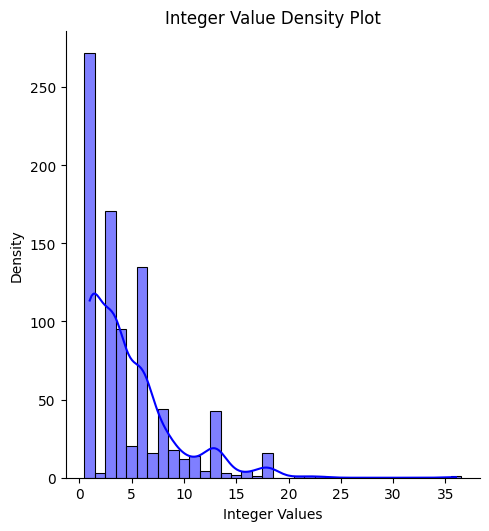

In [37]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 生成一组随机整数数据作为示例
data = np.array(key_num)

# # 使用 NumPy 的 `bincount` 函数统计整数分布
# counts = np.bincount(data)

# 使用 seaborn 绘制整数分布的密度图
sns.displot(data, kde=True, bins=np.arange(np.min(data)-0.5, np.max(data)+1.5, 1), color='blue')

plt.xlabel('Integer Values')
plt.ylabel('Density')
plt.title('Integer Value Density Plot')
plt.show()



In [5]:
import numpy as np

emb = np.ones(shape=(2,12))
padding = np.zeros(shape=(3, 12))
emb = np.concatenate([emb, padding])
emb.shape

(5, 12)

In [29]:
import torch
import torch.nn as nn

a = torch.randn(size=(3,3,3))
a[1:1]

(tensor([[[ 0.0806, -0.4482, -0.8190],
          [-1.1523, -0.1530, -0.5185],
          [-0.4260,  0.2769,  1.7381]]]),
 tensor([], size=(0, 3, 3)))